<a href="https://colab.research.google.com/github/Salma5806/ApplicationWeb/blob/main/yolo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow==2.15 keras==2.15



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.3/475.3 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 64.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 51.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 75.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 28.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 6.9 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.17.2
    Uninstalling wrapt-1.17.2:
      Successfully uninstalled wrapt-1.17.2
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: keras
    Found existing installation: keras 3.8.0
    Uninstalling keras-3.8.0:
      Successfully uninstalled keras-3.8.0
  Attempting uninstall: tensorboard
    Found existing installation

In [ ]:
import tensorflow.keras as K
import numpy as np

class Yolo:
    """Yolo class"""
    model = None
    class_names = None
    class_t = None
    nms_t = None
    anchors = None
    def __init__(self, model_path, classes_path, class_t, nms_t, anchors):
        """
        model_path is the path to where a Darknet Keras model is stored
        classes_path is the path to where the list of class names used for the Darknet model, listed in order of index, can be found
        class_t is a float representing the box score threshold for the initial filtering step
        nms_t is a float representing the IOU threshold for non-max suppression
        """
        self.model = K.models.load_model(model_path, compile=False)
        self.class_names = self._load_classes(classes_path)
        self.class_t = class_t
        self.nms_t = nms_t
        self.anchors = anchors
    def _load_classes(self, classes_path):
        with open(classes_path) as file:
            class_names = file.read().splitlines()
        return class_names

In [ ]:
np.random.seed(0)
anchors = np.array([[[116, 90], [156, 198], [373, 326]],
                        [[30, 61], [62, 45], [59, 119]],
                        [[10, 13], [16, 30], [33, 23]]])
yolo = Yolo('/content/yolo.h5', '/content/coco_classes.txt', 0.6, 0.5, anchors)
yolo.model.summary()
print('Class names:', yolo.class_names)
print('Class threshold:', yolo.class_t)
print('NMS threshold:', yolo.nms_t)
print('Anchor boxes:', yolo.anchors)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 416, 416, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 416, 416, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 416, 416, 32)         128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 leaky_re_lu (LeakyReLU)     (None, 416, 416, 32)         0         ['batch_normalization[0][0

In [ ]:
pw_total = anchors[..., 0]
print(pw_total)
grid_w = 3
pw = np.tile(pw_total[index], grid_w)

array([[116, 156, 373],
       [ 30,  62,  59],
       [ 10,  16,  33]])

In [ ]:
import tensorflow.keras as K
import numpy as np

class Yolo:
    """Yolo class"""
    model = None
    class_names = None
    class_t = None
    nms_t = None
    anchors = None
    def __init__(self, model_path, classes_path, class_t, nms_t, anchors):
        """
        model_path is the path to where a Darknet Keras model is stored
        classes_path is the path to where the list of class names used for the Darknet model, listed in order of index, can be found
        class_t is a float representing the box score threshold for the initial filtering step
        nms_t is a float representing the IOU threshold for non-max suppression
        """
        self.model = K.models.load_model(model_path, compile=False)
        self.class_names = self._load_classes(classes_path)
        self.class_t = class_t
        self.nms_t = nms_t
        self.anchors = anchors
    def _load_classes(self, classes_path):
        with open(classes_path) as file:
            class_names = file.read().splitlines()
        return class_names
    def process_outputs(self, outputs, image_size):
        boxes = []
        box_confidences = []
        box_class_probs = []

        image_height, image_width = image_size
        def sigmoid(x):
            z = 1/(1 + np.exp(-x))
            return z
        for i, output in enumerate(outputs):
            grid_h, grid_w, anchor_boxes, _ = output.shape
            tx = output[..., 0]
            ty = output[..., 1]
            tw = output[..., 2]
            th = output[..., 3]
            tx_sigmoid = sigmoid(tx)
            ty_sigmoid = sigmoid(ty)
            row = np.arange(grid_w)
            col = np.arange(grid_h)
            cx = np.tile(row, (grid_h, 1))
            cy = np.tile(col, (grid_w, 1))
            cx = cx.reshape(grid_w, grid_h, 1)
            cy = cy.reshape(grid_h, grid_w, 1)
            bx = (tx_sigmoid + cx) / grid_w
            by = (ty_sigmoid + cy) / grid_h
            bw = self.anchors[i][:, 0] * np.exp(tw) / image_width
            bh = self.anchors[i][:, 1] * np.exp(th) / image_height
            x1 = (bx - bw / 2) * image_width
            y1 = (by - bh / 2) * image_height
            x2 = (bx + bw / 2) * image_width
            y2 = (by + bh / 2) * image_height
            box = np.stack([x1, y1, x2, y2], axis=-1)
            boxes.append(box)
            conf = output[..., 4:5]
            box_conf = sigmoid(conf)
            box_confidences.append(box_conf)
            class_prob = output[..., 5:]
            box_class_prob = sigmoid(class_prob)
            box_class_probs.append(box_class_prob)
            return boxes, box_confidences, box_class_probs


In [ ]:
import tensorflow.keras as K
import numpy as np

class Yolo:
    """Yolo class"""
    model = None
    class_names = None
    class_t = None
    nms_t = None
    anchors = None

    def __init__(self, model_path, classes_path, class_t, nms_t, anchors):
        """
        model_path is the path to where a Darknet Keras model is stored
        classes_path is the path to where the list of class names used for the Darknet model, listed in order of index, can be found
        class_t is a float representing the box score threshold for the initial filtering step
        nms_t is a float representing the IOU threshold for non-max suppression
        """
        self.model = K.models.load_model(model_path, compile=False)
        self.class_names = self._load_classes(classes_path)
        self.class_t = class_t
        self.nms_t = nms_t
        self.anchors = anchors

    def _load_classes(self, classes_path):
        """Load class names from a file."""
        with open(classes_path) as file:
            class_names = file.read().splitlines()
        return class_names

    def process_outputs(self, outputs, image_size):
        """
        Process the outputs of the YOLO model.

        Args:
            outputs: List of numpy.ndarray containing the model outputs.
            image_size: Tuple (image_height, image_width) representing the original image size.

        Returns:
            boxes: List of numpy.ndarray containing the processed bounding boxes.
            box_confidences: List of numpy.ndarray containing the box confidences.
            box_class_probs: List of numpy.ndarray containing the box class probabilities.
        """
        boxes = []
        box_confidences = []
        box_class_probs = []

        image_height, image_width = image_size

        def sigmoid(x):
            """Sigmoid function."""
            return 1 / (1 + np.exp(-x))

        for i, output in enumerate(outputs):
            grid_h, grid_w, anchor_boxes, _ = output.shape

            # Extract predictions
            tx = output[..., 0]
            ty = output[..., 1]
            tw = output[..., 2]
            th = output[..., 3]
            box_confidence = output[..., 4:5]
            class_probs = output[..., 5:]

            # Apply sigmoid to tx, ty, box_confidence, and class_probs
            tx_sigmoid = sigmoid(tx)
            ty_sigmoid = sigmoid(ty)
            box_confidence_sigmoid = sigmoid(box_confidence)
            class_probs_sigmoid = sigmoid(class_probs)

            # Generate grid
            cx = np.tile(np.arange(grid_w).reshape(1, grid_w, 1), (grid_h, 1, anchor_boxes))
            cy = np.tile(np.arange(grid_h).reshape(grid_h, 1, 1), (1, grid_w, anchor_boxes))

            # Calculate bounding box coordinates
            bx = (tx_sigmoid + cx) / grid_w
            by = (ty_sigmoid + cy) / grid_h
            bw = (self.anchors[i][:, 0] * np.exp(tw)) / self.model.input.shape[1]
            bh = (self.anchors[i][:, 1] * np.exp(th)) / self.model.input.shape[2]

            # Convert to absolute coordinates
            x1 = (bx - bw / 2) * image_width
            y1 = (by - bh / 2) * image_height
            x2 = (bx + bw / 2) * image_width
            y2 = (by + bh / 2) * image_height

            # Stack coordinates to form bounding boxes
            box = np.stack([x1, y1, x2, y2], axis=-1)
            boxes.append(box)

            # Append confidences and class probabilities
            box_confidences.append(box_confidence_sigmoid)
            box_class_probs.append(class_probs_sigmoid)

        return boxes, box_confidences, box_class_probs
    def non_max_suppression(self, filtered_boxes, box_classes, box_scores):
        sorted_scores = np.argsort(box_scores)[::-1]
        filtered_boxes = filtered_boxes[sorted_scores]
        box_classes = box_classes[sorted_scores]
        box_scores = box_scores[sorted_scores]
        box_predictions = []
        # Parcourir les boîtes
        while len(filtered_boxes) > 0:
            # Ajouter la boîte avec le score le plus élevé à la liste `keep`
            box_predictions.append(sorted_scores[0])
        def _iou(box1, box2):
            """Calculate the Intersection over Union (IoU) of two boxes."""
            x1 = (box1[0], box2[0])
            y1 = (box1[1], box2[1])
            x2 = (box1[2], box2[2])
            y2 = (box1[3], box2[3])
            intersection_width = min(box1[2], box2[2]) - max(box1[0], box2[0])
            intersection_height = min(box1[3], box2[3]) - max(box1[1], box2[1])
            intersection_area = intersection_width * intersection_height
            union_area = (box1[2] - box1[0]) * (box1[3] - box1[1]) + (box2[2] - box2[0]) * (box2[3] - box2[1]) - intersection_area
            return intersection_area / union_area
        iou = self._iou(filtered_boxes[0], filtered_boxes[1:])
        filtered_boxes = filtered_boxes[iou >= self.nms_t]
        box_predictions.append(filtered_boxes)
        box_classes = box_classes[iou >= self.nms_t]
        box_scores = box_scores[iou >= self.nms_t]
        return box_predictions, box_classes, box_scores

In [ ]:
def non_max_suppression(self, filtered_boxes, box_classes, box_scores):
    sorted_scores = np.argsort(box_scores)[::-1]
    filtered_boxes = filtered_boxes[sorted_scores]
    box_classes = box_classes[sorted_scores]
    box_scores = box_scores[sorted_scores]
    box_predictions = []

    # Parcourir les boîtes
    while len(filtered_boxes) > 0:
        # Ajouter la boîte avec le score le plus élevé à la liste `keep`
        box_predictions.append(sorted_scores[0])
        def _iou(box1, box2):
            """Calculate the Intersection over Union (IoU) of two boxes."""
            x1 = (box1[0], box2[0])
            y1 = (box1[1], box2[1])
            x2 = (box1[2], box2[2])
            y2 = (box1[3], box2[3])
            intersection_width = min(box1[2], box2[2]) - max(box1[0], box2[0])
            intersection_height = min(box1[3], box2[3]) - max(box1[1], box2[1])
            intersection_area = intersection_width * intersection_height
            union_area = (box1[2] - box1[0]) * (box1[3] - box1[1]) + (box2[2] - box2[0]) * (box2[3] - box2[1]) - intersection_area
            return intersection_area / union_area
        iou = self._iou(filtered_boxes[0], filtered_boxes[1:])
        filtered_boxes = filtered_boxes[iou >= self.nms_t]
        box_predictions.append(filtered_boxes)
        box_classes = box_classes[iou >= self.nms_t]
        box_scores = box_scores[iou >= self.nms_t]
    return box_predictions, box_classes, box_scores


In [ ]:
np.random.seed(0)
anchors = np.array([[[116, 90], [156, 198], [373, 326]],
                        [[30, 61], [62, 45], [59, 119]],
                        [[10, 13], [16, 30], [33, 23]]])
yolo = Yolo('yolo.h5', 'coco_classes.txt', 0.6, 0.5, anchors)
output1 = np.random.randn(13, 13, 3, 85)
output2 = np.random.randn(26, 26, 3, 85)
output3 = np.random.randn(52, 52, 3, 85)
boxes, box_confidences, box_class_probs = yolo.process_outputs([output1, output2, output3], np.array([500, 700]))
print('Boxes:', boxes)
print('Box confidences:', box_confidences)
print('Box class probabilities:', box_class_probs)

Boxes: [array([[[[-2.13743365e+02, -4.85478868e+02,  3.05682061e+02,
           5.31534670e+02],
         [-6.28222336e+01, -1.13713822e+01,  1.56452678e+02,
           7.01966357e+01],
         [-7.00753664e+02, -7.99011810e+01,  7.77777040e+02,
           1.24440730e+02]],

        [[ 6.52921110e+01,  1.43688377e+00,  1.14233396e+02,
           2.36524697e+01],
         [ 2.79501974e+01, -2.03937627e+01,  1.59898932e+02,
           5.02826906e+01],
         [ 6.17629106e+01, -8.31889643e+01,  1.02303202e+02,
           1.38551621e+02]],

        [[ 1.20166765e+02,  2.31461495e+01,  1.71676644e+02,
           3.82523882e+01],
         [ 3.39847297e+01, -3.21481177e+01,  2.45335593e+02,
           6.17333839e+01],
         [-5.41077407e+02, -4.37386113e+02,  7.94834201e+02,
           4.95448229e+02]],

        ...,

        [[ 4.37830908e+02, -1.12792212e+02,  6.59360033e+02,
           1.26273767e+02],
         [ 4.40039718e+02, -1.34968536e+02,  6.70734974e+02,
           1.75141946

In [ ]:
import numpy as np

# Paramètres
image_width, image_height = 60, 60
grid_w, grid_h = 3, 3  # La grille est de 3x3
num_anchors = 3  # Chaque cellule contient 3 boîtes d'ancrage

# Simuler une sortie aléatoire du modèle YOLO (shape = (grid_h, grid_w, num_anchors, 5))
np.random.seed(42)  # Pour des résultats reproductibles
output = np.random.uniform(-1, 1, (grid_h, grid_w, num_anchors, 5))  # 5 -> tx, ty, tw, th, confidence

# Étape 1: Extraire tx et ty sous forme d'array
tx = output[..., 0]  # tx a la shape (3, 3, 3)
ty = output[..., 1]  # ty a la shape (3, 3, 3)
tw = output[..., 2]
th = output[..., 3]

# Étape 2: Générer cx et cy (coordonnées de la grille)
cx = np.tile(np.arange(grid_w), (grid_h, 1))  # Shape (3,3)
cx = np.expand_dims(cx, axis=-1)  # Shape (3,3,1) pour le broadcasting

cy = np.tile(np.arange(grid_h).reshape(-1, 1), (1, grid_w))  # Shape (3,3)
cy = np.expand_dims(cy, axis=-1)  # Shape (3,3,1)

# Étape 3: Appliquer la sigmoïde à tx et ty
sigmoid = lambda x: 1 / (1 + np.exp(-x))
tx_sigmoid = sigmoid(tx)
ty_sigmoid = sigmoid(ty)

# Étape 4: Additionner cx et cy
bx_norm = (tx_sigmoid + cx) / grid_w  # Shape (3,3,3)
by_norm = (ty_sigmoid + cy) / grid_h  # Shape (3,3,3)

# Étape 5: Convertir en pixels
bx = bx_norm * image_width  # Shape (3,3,3)
by = by_norm * image_height  # Shape (3,3,3)



In [ ]:
output

array([[[[-0.25091976,  0.90142861,  0.46398788,  0.19731697,
          -0.68796272],
         [-0.68801096, -0.88383278,  0.73235229,  0.20223002,
           0.41614516],
         [-0.95883101,  0.9398197 ,  0.66488528, -0.57532178,
          -0.63635007]],

        [[-0.63319098, -0.39151551,  0.04951286, -0.13610996,
          -0.41754172],
         [ 0.22370579, -0.72101228, -0.4157107 , -0.26727631,
          -0.08786003],
         [ 0.57035192, -0.60065244,  0.02846888,  0.18482914,
          -0.90709917]],

        [[ 0.2150897 , -0.65895175, -0.86989681,  0.89777107,
           0.93126407],
         [ 0.6167947 , -0.39077246, -0.80465577,  0.36846605,
          -0.11969501],
         [-0.75592353, -0.00964618, -0.93122296,  0.8186408 ,
          -0.48244004]]],


       [[[ 0.32504457, -0.37657785,  0.04013604,  0.09342056,
          -0.63029109],
         [ 0.93916926,  0.55026565,  0.87899788,  0.7896547 ,
           0.19579996],
         [ 0.84374847, -0.823015  , -0.6080342

In [ ]:
tx = output[..., 0]

In [ ]:
tx

array([[[-0.50183952, -1.37602192, -1.91766202],
        [-1.26638196,  0.44741158,  1.14070385],
        [ 0.43017941,  1.23358939, -1.51184706]],

       [[ 0.65008914,  1.87833851,  1.68749694],
        [-0.44529084,  0.17078433,  1.08897908],
        [ 0.91602867,  1.4524137 , -0.69926671]],

       [[-1.52162302, -0.02481761, -1.87428326],
        [-1.00283108, -0.84099419,  1.48584236],
        [ 1.22976062, -0.29156885, -0.33035599]]])

In [ ]:
 cx = np.tile(np.arange(grid_w), grid_h).reshape(grid_w, grid_h, 1)
 cy = np.tile(np.arange(grid_h), grid_w).reshape(grid_h, grid_w, 1).T

In [ ]:
l = np.arange(grid_w)

In [ ]:
l

array([0, 1, 2])

In [ ]:
c = np.tile(l, grid_h,)

In [ ]:
c

array([0, 1, 2, 0, 1, 2, 0, 1, 2])

In [ ]:
m = c.reshape(grid_w, grid_h, 1)

In [ ]:
m


array([[[0],
        [1],
        [2]],

       [[0],
        [1],
        [2]],

       [[0],
        [1],
        [2]]])

In [ ]:
l2 = np.arange(grid_h)
print(l2)
c = np.tile(l2, grid_w)
print(c)
m2 = c.reshape(grid_h, grid_w, 1).T
print(m2)

[0 1 2]
[0 1 2 0 1 2 0 1 2]
[[[0 0 0]
  [1 1 1]
  [2 2 2]]]


In [ ]:
cx

array([[[0],
        [1],
        [2]],

       [[0],
        [1],
        [2]],

       [[0],
        [1],
        [2]]])

In [ ]:
sigmoid = lambda x: 1 / (1 + np.exp(-x))
tx_sigmoid = sigmoid(tx)

In [ ]:
tx_sigmoid

array([[[0.43759713, 0.33447569, 0.27711231],
        [0.34678735, 0.55569438, 0.63884438],
        [0.55356607, 0.6494892 , 0.31953197]],

       [[0.58055316, 0.71893182, 0.6992541 ],
        [0.44456744, 0.52133508, 0.63285618],
        [0.61254302, 0.67397234, 0.41347133]],

       [[0.3184701 , 0.49689784, 0.28147808],
        [0.37720807, 0.39639781, 0.67763431],
        [0.64905326, 0.46361831, 0.45879914]]])

In [ ]:
bx_norm = (tx_sigmoid + cx) / grid_w
bx = bx_norm * image_width
bx

array([[[ 8.75194254,  6.68951382,  5.54224614],
        [26.9357469 , 31.11388751, 32.77688751],
        [51.07132144, 52.98978403, 46.39063931]],

       [[11.61106316, 14.37863641, 13.98508199],
        [28.89134886, 30.42670158, 32.65712359],
        [52.25086032, 53.47944682, 48.26942668]],

       [[ 6.3694021 ,  9.93795676,  5.62956163],
        [27.54416138, 27.92795612, 33.55268615],
        [52.98106523, 49.27236614, 49.1759827 ]]])

In [ ]:
bx = tx_sigmoid + cx
bx

array([[[0.43759713, 0.33447569, 0.27711231],
        [1.34678735, 1.55569438, 1.63884438],
        [2.55356607, 2.6494892 , 2.31953197]],

       [[0.58055316, 0.71893182, 0.6992541 ],
        [1.44456744, 1.52133508, 1.63285618],
        [2.61254302, 2.67397234, 2.41347133]],

       [[0.3184701 , 0.49689784, 0.28147808],
        [1.37720807, 1.39639781, 1.67763431],
        [2.64905326, 2.46361831, 2.45879914]]])

In [ ]:
pw_total = num_anchors[:, :, 0]
pw_total

TypeError: 'int' object is not subscriptable

In [ ]:
from genericpath import exists
import tensorflow.keras as K
import numpy as np
import cv2
import os

class Yolo:
    """Yolo class"""
    model = None
    class_names = None
    class_t = None
    nms_t = None
    anchors = None

    def __init__(self, model_path, classes_path, class_t, nms_t, anchors):
        """
        model_path is the path to where a Darknet Keras model is stored
        classes_path is the path to where the list of class names used for the Darknet model, listed in order of index, can be found
        class_t is a float representing the box score threshold for the initial filtering step
        nms_t is a float representing the IOU threshold for non-max suppression
        """
        self.model = K.models.load_model(model_path, compile=False)
        self.class_names = self._load_classes(classes_path)
        self.class_t = class_t
        self.nms_t = nms_t
        self.anchors = anchors

    def _load_classes(self, classes_path):
        """Load class names from a file."""
        with open(classes_path) as file:
            class_names = file.read().splitlines()
        return class_names

    def process_outputs(self, outputs, image_size):
        """
        Process the outputs of the YOLO model.

        Args:
            outputs: List of numpy.ndarray containing the model outputs.
            image_size: Tuple (image_height, image_width) representing the original image size.

        Returns:
            boxes: List of numpy.ndarray containing the processed bounding boxes.
            box_confidences: List of numpy.ndarray containing the box confidences.
            box_class_probs: List of numpy.ndarray containing the box class probabilities.
        """
        boxes = []
        box_confidences = []
        box_class_probs = []

        image_height, image_width = image_size

        def sigmoid(x):
            """Sigmoid function."""
            return 1 / (1 + np.exp(-x))

        for i, output in enumerate(outputs):
            grid_h, grid_w, anchor_boxes, _ = output.shape

            # Extract predictions
            tx = output[..., 0]
            ty = output[..., 1]
            tw = output[..., 2]
            th = output[..., 3]
            box_confidence = output[..., 4:5]
            class_probs = output[..., 5:]

            # Apply sigmoid to tx, ty, box_confidence, and class_probs
            tx_sigmoid = sigmoid(tx)
            ty_sigmoid = sigmoid(ty)
            box_confidence_sigmoid = sigmoid(box_confidence)
            class_probs_sigmoid = sigmoid(class_probs)

            # Generate grid
            cx = np.tile(np.arange(grid_w).reshape(1, grid_w, 1), (grid_h, 1, anchor_boxes))
            cy = np.tile(np.arange(grid_h).reshape(grid_h, 1, 1), (1, grid_w, anchor_boxes))

            # Calculate bounding box coordinates
            bx = (tx_sigmoid + cx) / grid_w
            by = (ty_sigmoid + cy) / grid_h
            bw = (self.anchors[i][:, 0] * np.exp(tw)) / self.model.input.shape[1]
            bh = (self.anchors[i][:, 1] * np.exp(th)) / self.model.input.shape[2]

            # Convert to absolute coordinates
            x1 = (bx - bw / 2) * image_width
            y1 = (by - bh / 2) * image_height
            x2 = (bx + bw / 2) * image_width
            y2 = (by + bh / 2) * image_height

            # Stack coordinates to form bounding boxes
            box = np.stack([x1, y1, x2, y2], axis=-1)
            boxes.append(box)

            # Append confidences and class probabilities
            box_confidences.append(box_confidence_sigmoid)
            box_class_probs.append(class_probs_sigmoid)

        return boxes, box_confidences, box_class_probs
    def filter_boxes(self, boxes, box_confidences, box_class_probs):
        """
        Filter boxes based on confidence scores and class probabilities.
        Args:
        boxes: List of numpy.ndarray of shape (grid_height, grid_width, anchor_boxes, 4)
               containing the processed boundary boxes.
        box_confidences: List of numpy.ndarray of shape (grid_height, grid_width, anchor_boxes, 1)
                         containing the processed box confidences.
        box_class_probs: List of numpy.ndarray of shape (grid_height, grid_width, anchor_boxes, classes)
                         containing the processed box class probabilities.
                         Returns:
        filtered_boxes: numpy.ndarray of shape (?, 4) containing the filtered bounding boxes.
        box_classes: numpy.ndarray of shape (?,) containing the class number for each filtered box.
        box_scores: numpy.ndarray of shape (?) containing the box scores for each filtered box.
        """
        # Flatten the lists of arrays into single arrays
        boxes = np.concatenate([box.reshape(-1, 4) for box in boxes], axis=0)
        box_confidences = np.concatenate([confidence.reshape(-1) for confidence in box_confidences], axis=0)
        box_class_probs = np.concatenate([probs.reshape(-1, probs.shape[-1]) for probs in box_class_probs], axis=0)
        # Calculate box scores by multiplying confidence and class probabilities
        box_scores = box_confidences.reshape(-1, 1) * box_class_probs
        # Find the class with the maximum score for each box
        box_classes = np.argmax(box_scores, axis=-1)
        box_class_scores = np.max(box_scores, axis=-1)
        # Filter out boxes with low scores (e.g., below a threshold)
        filtering_mask = box_class_scores >= self.class_t
        filtered_boxes = boxes[filtering_mask]
        filtered_classes = box_classes[filtering_mask]
        filtered_scores = box_class_scores[filtering_mask]
        return filtered_boxes, filtered_classes, filtered_scores
    import tensorflow.keras as K
import numpy as np

class Yolo:
    """Yolo class"""
    model = None
    class_names = None
    class_t = None
    nms_t = None
    anchors = None

    def __init__(self, model_path, classes_path, class_t, nms_t, anchors):
        """
        model_path is the path to where a Darknet Keras model is stored
        classes_path is the path to where the list of class names used for the Darknet model, listed in order of index, can be found
        class_t is a float representing the box score threshold for the initial filtering step
        nms_t is a float representing the IOU threshold for non-max suppression
        """
        self.model = K.models.load_model(model_path, compile=False)
        self.class_names = self._load_classes(classes_path)
        self.class_t = class_t
        self.nms_t = nms_t
        self.anchors = anchors

    def _load_classes(self, classes_path):
        """Load class names from a file."""
        with open(classes_path) as file:
            class_names = file.read().splitlines()
        return class_names

    def process_outputs(self, outputs, image_size):
        """
        Process the outputs of the YOLO model.

        Args:
            outputs: List of numpy.ndarray containing the model outputs.
            image_size: Tuple (image_height, image_width) representing the original image size.

        Returns:
            boxes: List of numpy.ndarray containing the processed bounding boxes.
            box_confidences: List of numpy.ndarray containing the box confidences.
            box_class_probs: List of numpy.ndarray containing the box class probabilities.
        """
        boxes = []
        box_confidences = []
        box_class_probs = []

        image_height, image_width = image_size

        def sigmoid(x):
            """Sigmoid function."""
            return 1 / (1 + np.exp(-x))

        for i, output in enumerate(outputs):
            # Vérifier la forme de l'output
            if len(output.shape) != 5:
                raise ValueError(f"Output shape {output.shape} is not compatible. Expected 5 dimensions.")

            # Supprimer la dimension batch (batch_size = 1)
            output = output[0]  # Forme attendue : (grid_h, grid_w, anchor_boxes, 85)

            grid_h, grid_w, anchor_boxes, _ = output.shape

            # Extract predictions
            tx = output[..., 0]
            ty = output[..., 1]
            tw = output[..., 2]
            th = output[..., 3]
            box_confidence = output[..., 4:5]
            class_probs = output[..., 5:]

            # Apply sigmoid to tx, ty, box_confidence, and class_probs
            tx_sigmoid = sigmoid(tx)
            ty_sigmoid = sigmoid(ty)
            box_confidence_sigmoid = sigmoid(box_confidence)
            class_probs_sigmoid = sigmoid(class_probs)

            # Generate grid
            cx = np.tile(np.arange(grid_w).reshape(1, grid_w, 1), (grid_h, 1, anchor_boxes))
            cy = np.tile(np.arange(grid_h).reshape(grid_h, 1, 1), (1, grid_w, anchor_boxes))

            # Calculate bounding box coordinates
            bx = (tx_sigmoid + cx) / grid_w
            by = (ty_sigmoid + cy) / grid_h
            bw = (self.anchors[i][:, 0] * np.exp(tw)) / self.model.input.shape[1]
            bh = (self.anchors[i][:, 1] * np.exp(th)) / self.model.input.shape[2]

            # Convert to absolute coordinates
            x1 = (bx - bw / 2) * image_width
            y1 = (by - bh / 2) * image_height
            x2 = (bx + bw / 2) * image_width
            y2 = (by + bh / 2) * image_height

            # Stack coordinates to form bounding boxes
            box = np.stack([x1, y1, x2, y2], axis=-1)
            boxes.append(box)

            # Append confidences and class probabilities
            box_confidences.append(box_confidence_sigmoid)
            box_class_probs.append(class_probs_sigmoid)

        return boxes, box_confidences, box_class_probs

    def filter_boxes(self, boxes, box_confidences, box_class_probs):
        """
        Filter boxes based on confidence scores and class probabilities.

        Args:
            boxes: List of numpy.ndarray of shape (grid_height, grid_width, anchor_boxes, 4)
                   containing the processed boundary boxes.
            box_confidences: List of numpy.ndarray of shape (grid_height, grid_width, anchor_boxes, 1)
                             containing the processed box confidences.
            box_class_probs: List of numpy.ndarray of shape (grid_height, grid_width, anchor_boxes, classes)
                             containing the processed box class probabilities.

        Returns:
            filtered_boxes: numpy.ndarray of shape (?, 4) containing the filtered bounding boxes.
            box_classes: numpy.ndarray of shape (?,) containing the class number for each filtered box.
            box_scores: numpy.ndarray of shape (?) containing the box scores for each filtered box.
        """
        # Flatten the lists of arrays into single arrays
        boxes = np.concatenate([box.reshape(-1, 4) for box in boxes], axis=0)
        box_confidences = np.concatenate([confidence.reshape(-1) for confidence in box_confidences], axis=0)
        box_class_probs = np.concatenate([probs.reshape(-1, probs.shape[-1]) for probs in box_class_probs], axis=0)

        # Calculate box scores by multiplying confidence and class probabilities
        box_scores = box_confidences.reshape(-1, 1) * box_class_probs

        # Find the class with the maximum score for each box
        box_classes = np.argmax(box_scores, axis=-1)
        box_class_scores = np.max(box_scores, axis=-1)

        # Filter out boxes with low scores (e.g., below a threshold)
        filtering_mask = box_class_scores >= self.class_t
        filtered_boxes = boxes[filtering_mask]
        filtered_classes = box_classes[filtering_mask]
        filtered_scores = box_class_scores[filtering_mask]

        return filtered_boxes, filtered_classes, filtered_scores
    import numpy as np

    def non_max_suppression(self, filtered_boxes, box_classes, box_scores):
        """
        Perform non-max suppression on the filtered boxes.

        Args:
            filtered_boxes: numpy.ndarray of shape (?, 4) containing the filtered bounding boxes.
            box_classes: numpy.ndarray of shape (?,) containing the class numbers for each box.
            box_scores: numpy.ndarray of shape (?,) containing the box scores for each box.

        Returns:
            box_predictions: numpy.ndarray of shape (?, 4) containing the final bounding boxes.
            predicted_box_classes: numpy.ndarray of shape (?,) containing the class numbers for the final boxes.
            predicted_box_scores: numpy.ndarray of shape (?,) containing the scores for the final boxes.
        """
        def calculate_iou(box1, boxes):
            """
            Calculate the Intersection over Union (IoU) between a box and a list of boxes.
            """
            x1 = np.maximum(box1[0], boxes[:, 0])
            y1 = np.maximum(box1[1], boxes[:, 1])
            x2 = np.minimum(box1[2], boxes[:, 2])
            y2 = np.minimum(box1[3], boxes[:, 3])

            intersection_width = np.maximum(0, x2 - x1)
            intersection_height = np.maximum(0, y2 - y1)
            intersection_area = intersection_width * intersection_height

            box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
            boxes_area = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])

            union_area = box1_area + boxes_area - intersection_area
            iou = intersection_area / (union_area + 1e-6)  # Éviter division par 0

            return iou

        keep_boxes, keep_classes, keep_scores = [], [], []

        for cls in np.unique(box_classes):
            idx = np.where(box_classes == cls)[0]
            b, s =filtered_boxes[idx], box_scores[idx]
            order = np.argsort(s)[::-1]

            while len(order) > 0:
                best = order[0]
                keep_boxes.append(b[best])
                keep_classes.append(cls)
                keep_scores.append(s[best])

                if len(order) == 1:
                    break

                ious = calculate_iou(b[best], b[order[1:]])
                order = order[1:][ious < self.nms_t]

        return np.array(keep_boxes), np.array(keep_classes), np.array(keep_scores)
    def load_images(self, folder_path):
        images = []
        images_paths = []

        for filename in os.listdir(folder_path):  # Liste les fichiers dans le dossier
            img_path = os.path.join(folder_path, filename)  # Construit le chemin complet
            img = cv2.imread(img_path)  # Charge l'image

            if img is not None:  # Vérifie que l'image est bien chargée
                images.append(img)
                images_paths.append(img_path)

        return images, images_paths  # Retourne les images et leurs chemins

    def preprocess_images(self, images):
        """
        Preprocess a list of images for input into the Darknet model.

        Args:
            images: A list of images as numpy.ndarrays.

        Returns:
            A tuple of (pimages, image_shapes):
                pimages: A numpy.ndarray of shape (ni, input_h, input_w, 3) containing all preprocessed images.
                image_shapes: A numpy.ndarray of shape (ni, 2) containing the original height and width of the images.
        """
        pimages = []
        image_shapes = []

        # Récupérer les dimensions d'entrée du modèle
        input_h, input_w = self.model.input.shape[1], self.model.input.shape[2]

        for img in images:
            # Récupérer la taille originale
            original_height, original_width = img.shape[:2]
            image_shapes.append((original_height, original_width))

            # Redimensionner l'image
            resized_image = cv2.resize(img, (input_w, input_h), interpolation=cv2.INTER_CUBIC)

            # Normaliser les pixels [0,1]
            normalized_image = resized_image.astype(np.float32) / 255.0

            pimages.append(normalized_image)

        return np.array(pimages), np.array(image_shapes)



    from google.colab.patches import cv2_imshow  # Importer cv2_imshow pour Google Colab

    def show_boxes(self, image, boxes, box_classes, box_scores, file_name):
        """
        Draw bounding boxes on an image.

        Args:
            image: A numpy.ndarray representing the image.
            boxes: A numpy.ndarray of shape (n, 4) containing bounding box coordinates [x1, y1, x2, y2].
            box_classes: A numpy.ndarray of shape (n,) containing class indices for each box.
            box_scores: A numpy.ndarray of shape (n,) containing confidence scores for each box.
            file_name: The name of the file where the image should be saved.
        """
        # Faire une copie de l'image pour ne pas modifier l'originale
        image_copy = image.copy()

        # Convertir les coordonnées des boîtes en entiers
        boxes = boxes.astype(int)

        # Boucler sur chaque boîte, classe et score
        for box, cls_id, score in zip(boxes, box_classes, box_scores):
            # Extraire les coordonnées de la boîte
            x1, y1, x2, y2 = box

            # Dessiner la boîte en bleu (épaisseur 2)
            color = (255, 0, 0)  # Bleu en BGR
            thickness = 2
            cv2.rectangle(image_copy, (x1, y1), (x2, y2), color, thickness)

            # Préparer le texte (classe et score)
            class_name = str(self.class_names[cls_id])  # Récupérer le nom de la classe
            text = f"{class_name} {score:.2f}"  # Format : "classe score"

            # Définir les paramètres du texte
            font = cv2.FONT_HERSHEY_SIMPLEX
            font_scale = 0.5
            text_color = (0, 0, 255)  # Rouge en BGR
            text_thickness = 1

            # Calculer la position du texte (5 pixels au-dessus de la boîte)
            text_x = x1
            text_y = y1 - 5 if y1 - 5 > 0 else y1 + 20  # Si le texte dépasse, le mettre en dessous

            # Ajouter le texte à l'image
            cv2.putText(
                image_copy,
                text,
                (text_x, text_y),
                font,
                font_scale,
                text_color,
                text_thickness,
                cv2.LINE_AA,
            )

        # Afficher l'image dans Google Colab
        cv2_imshow(image_copy)  # Utiliser cv2_imshow pour Colab

        # Attendre une touche (non disponible dans Colab, donc on utilise input())
        print("Appuyez sur Entrée pour continuer...")
        input()

        # Sauvegarder l'image si 's' est pressé
        key = 0xFF
        if key == ord('s'):
            save_path = "detections"
            if not os.path.exists(save_path):
                os.mkdir(save_path)
            save_file = os.path.join(save_path, file_name)
            cv2.imwrite(save_file, image_copy)
        cv2.destroyAllWindows()


        return image_copy
    def predict(self, folder_path):
        """
        Predict objects in all images from a folder.

        Args:
            folder_path: A string representing the path to the folder containing images.

        Returns:
            A tuple of (predictions, image_paths):
                predictions: A list of tuples for each image of (boxes, box_classes, box_scores).
                image_paths: A list of image paths corresponding to each prediction.
        """
        predictions = []
        image_paths = []

        # Charger les images
        images, image_paths = self.load_images(folder_path)

        # Prétraiter les images
        pimages, image_shapes = self.preprocess_images(images)

        # Prédire les objets dans chaque image
        for i, image in enumerate(pimages):
            # Ajouter une dimension batch
            input_image = np.expand_dims(image, axis=0)

            # Appliquer le modèle YOLO
            model_outputs = self.model.predict(input_image)
            boxes, box_confidences, box_class_probs = self.process_outputs(model_outputs, image_shapes[i])
            boxes, box_classes, box_scores = self.filter_boxes(boxes, box_confidences, box_class_probs)
            boxes, box_classes, box_scores = self.non_max_suppression(boxes, box_classes, box_scores)

            # Afficher les résultats
            self.show_boxes(images[i], boxes, box_classes, box_scores, os.path.basename(image_paths[i]))

            # Stocker les prédictions
            predictions.append((boxes, box_classes, box_scores))

        return predictions, image_paths





In [ ]:
np.random.seed(0)
anchors = np.array([[[116, 90], [156, 198], [373, 326]],
                        [[30, 61], [62, 45], [59, 119]],
                        [[10, 13], [16, 30], [33, 23]]])
yolo = Yolo('yolo.h5', 'coco_classes.txt', 0.6, 0.5, anchors)
predictions, image_paths = yolo.predict('/content/yolo')
for i, name in enumerate(image_paths):
    if "dog.jpg" in name:
        ind = i
        break
print(image_paths[ind])
print(predictions[ind])

1/1 [==============================] - 3s 3s/step


ValueError: Output shape (1, 13, 13, 3, 85) is not compatible. Expected 5 dimensions.

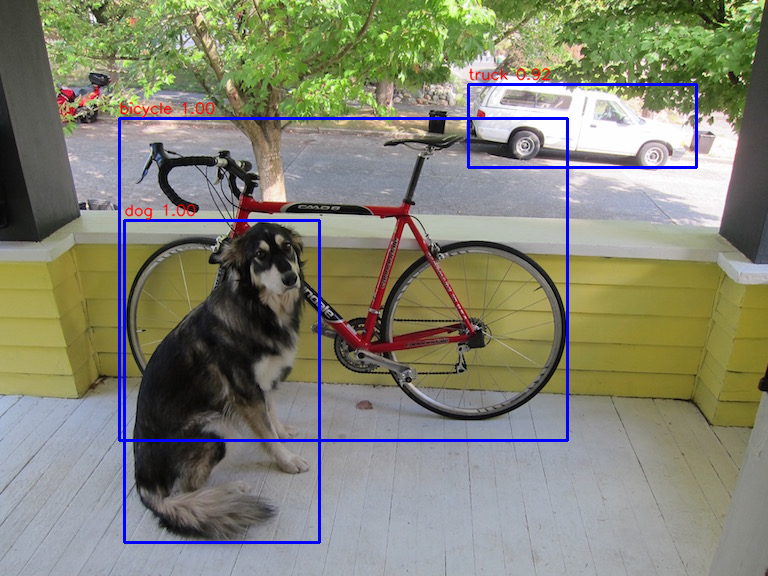

Appuyez sur Entrée pour continuer...


KeyboardInterrupt: Interrupted by user

In [ ]:
from google.colab.patches import cv2_imshow
np.random.seed(0)
anchors = np.array([[[116, 90], [156, 198], [373, 326]],
                        [[30, 61], [62, 45], [59, 119]],
                        [[10, 13], [16, 30], [33, 23]]])
yolo = Yolo('yolo.h5', 'coco_classes.txt', 0.6, 0.5, anchors)
images, image_paths = yolo.load_images('/content/yolo')
boxes = np.array([[119.22100287, 118.62197718, 567.75985556, 440.44121152],
                      [468.53530752, 84.48338278, 696.04923556, 167.98947829],
                      [124.2043716, 220.43365057, 319.4254314 , 542.13706101]])
box_scores = np.array([0.99537075, 0.91536146, 0.9988506])
box_classes = np.array([1, 7, 16])
ind = 0
for i, name in enumerate(image_paths):
    if "dog.jpg" in name:
        ind = i
        break
i = yolo.show_boxes(images[i], boxes, box_classes, box_scores, "dog.jpg")


stretch_near = cv2.resize(image, (780, 540),
               interpolation = cv2.INTER_LINEAR)


<class 'numpy.ndarray'> (6, 416, 416, 3)
<class 'numpy.ndarray'> (6, 2)
(576, 768, 3) : [576 768]


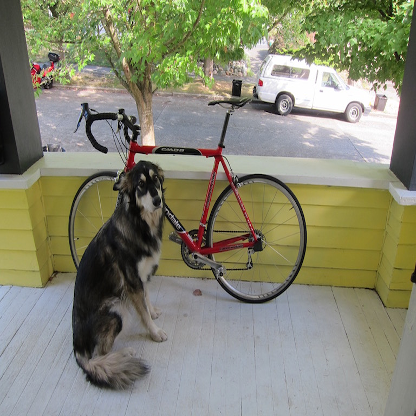

In [ ]:
from google.colab.patches import cv2_imshow

np.random.seed(2)
anchors = np.array([[[116, 90], [156, 198], [373, 326]],
                        [[30, 61], [62, 45], [59, 119]],
                        [[10, 13], [16, 30], [33, 23]]])
yolo = Yolo('yolo.h5', 'coco_classes.txt', 0.6, 0.5, anchors)
images, image_paths = yolo.load_images('/content/yolo')
image_paths, images = zip(*sorted(zip(image_paths, images)))
pimages, image_shapes = yolo.preprocess_images(images)
print(type(pimages), pimages.shape)
print(type(image_shapes), image_shapes.shape)
i = np.random.randint(0, len(images))
print(images[i].shape, ':', image_shapes[i])
#cv2_imshow(image_paths[i], pimages[i])
cv2_imshow((pimages[i] * 255))
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
import cv2
def load_images(folder_path):
    images = []
    images_paths = []
    f = open("folder_path", r)
    for paths in f:
        images.append(cv2.imread(images_paths))
        images_paths.append(paths)
        return images, images_paths

In [ ]:
!pip install --upgrade opencv-python opencv-python-headless


0
/lib64/yolo/dog.jpg


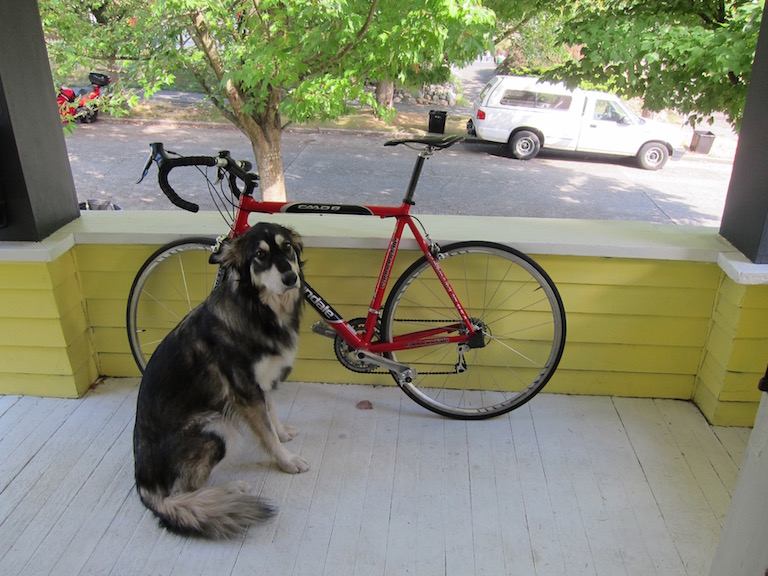

In [ ]:
from google.colab.patches import cv2_imshow

# Affichage de l'image
yolo = Yolo('yolo.h5', 'coco_classes.txt', 0.6, 0.5, anchors)
np.random.seed(2)
np.random.seed(2)
anchors = np.array([[[116, 90], [156, 198], [373, 326]],
                            [[30, 61], [62, 45], [59, 119]],
                            [[10, 13], [16, 30], [33, 23]]])
yolo = Yolo('yolo.h5', 'coco_classes.txt', 0.6, 0.5, anchors)
images, image_paths = yolo.load_images('/lib64/yolo/')
image_paths, images = zip(*sorted(zip(image_paths, images)))
i = np.random.randint(0, len(images))
print(i)
print(image_paths[i])
cv2_imshow(images[i])
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
np.random.seed(0)
anchors = np.array([[[116, 90], [156, 198], [373, 326]],
                        [[30, 61], [62, 45], [59, 119]],
                        [[10, 13], [16, 30], [33, 23]]])
yolo = Yolo('yolo.h5', 'coco_classes.txt', 0.6, 0.5, anchors)
output1 = np.random.randn(13, 13, 3, 85)
output2 = np.random.randn(26, 26, 3, 85)
output3 = np.random.randn(52, 52, 3, 85)
boxes, box_confidences, box_class_probs = yolo.process_outputs([output1, output2, output3], np.array([500, 700]))
boxes, box_classes, box_scores = yolo.filter_boxes(boxes, box_confidences, box_class_probs)
print('Boxes:', boxes)
print('Box classes:', box_classes)
print('Box scores:', box_scores)

Boxes: [[-213.74336488 -485.47886784  305.68206077  531.53467019]
 [ -62.82223363  -11.37138215  156.45267787   70.19663572]
 [ 190.62733946    7.65943712  319.201764     43.75737906]
 ...
 [ 647.78041714  491.58472667  662.00736941  502.60750466]
 [ 586.27543101  487.95333873  715.85860922  499.39422783]
 [ 666.1128673   481.29683099  728.88754319  501.09378706]]
Box classes: [19 54 29 ... 63 25 46]
Box scores: [0.7850503  0.67898563 0.81301861 ... 0.8012832  0.61427808 0.64562072]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import numpy as np
np.random.seed(0)
anchors = np.array([[[116, 90], [156, 198], [373, 326]],
                        [[30, 61], [62, 45], [59, 119]],
                        [[10, 13], [16, 30], [33, 23]]])
yolo = Yolo('yolo.h5', 'coco_classes.txt', 0.6, 0.5, anchors)
output1 = np.random.randn(13, 13, 3, 85)
output2 = np.random.randn(26, 26, 3, 85)
output3 = np.random.randn(52, 52, 3, 85)
boxes, box_confidences, box_class_probs = yolo.process_outputs([output1, output2, output3], np.array([500, 700]))
boxes, box_classes, box_scores = yolo.filter_boxes(boxes, box_confidences, box_class_probs)
boxes, box_classes, box_scores = yolo.non_max_suppression(boxes, box_classes, box_scores)
print('Boxes:', boxes)
print('Box classes:', box_classes)

print('Box scores:', box_scores)

Boxes: [[483.49145347 128.010205   552.78146847 147.87465464]
 [-38.91328475 332.66704009 102.94594841 363.78584864]
 [ 64.10861893 329.13266621 111.87941603 358.37523958]
 ...
 [130.0729606  467.20024928 172.42160784 515.90336094]
 [578.82381106  76.25699693 679.22893305 104.63320075]
 [169.12132771 304.32765204 251.1457077  342.16397829]]
Box classes: [ 0  0  0 ... 79 79 79]
Box scores: [0.80673525 0.80405611 0.78972362 ... 0.61758194 0.61455015 0.6001824 ]


In [ ]:
np.random.seed(0)
anchors = np.array([[[116, 90], [156, 198], [373, 326]],
                        [[30, 61], [62, 45], [59, 119]],
                        [[10, 13], [16, 30], [33, 23]]])
yolo = Yolo('yolo.h5', 'coco_classes.txt', 0.6, 0.5, anchors)
output1 = np.random.randn(13, 13, 3, 85)
output2 = np.random.randn(26, 26, 3, 85)
output3 = np.random.randn(52, 52, 3, 85)
boxes, box_confidences, box_class_probs = yolo.process_outputs([output1, output2, output3], np.array([500, 700]))
print('Boxes:', boxes)
print('Box confidences:', box_confidences)
print('Box class probabilities:', box_class_probs)

Boxes: [array([[[[-2.13743365e+02, -4.85478868e+02,  3.05682061e+02,
           5.31534670e+02],
         [-6.28222336e+01, -1.13713822e+01,  1.56452678e+02,
           7.01966357e+01],
         [-7.00753664e+02, -7.99011810e+01,  7.77777040e+02,
           1.24440730e+02]],

        [[ 6.52921110e+01,  1.43688377e+00,  1.14233396e+02,
           2.36524697e+01],
         [ 2.79501974e+01, -2.03937627e+01,  1.59898932e+02,
           5.02826906e+01],
         [ 6.17629106e+01, -8.31889643e+01,  1.02303202e+02,
           1.38551621e+02]],

        [[ 1.20166765e+02,  2.31461495e+01,  1.71676644e+02,
           3.82523882e+01],
         [ 3.39847297e+01, -3.21481177e+01,  2.45335593e+02,
           6.17333839e+01],
         [-5.41077407e+02, -4.37386113e+02,  7.94834201e+02,
           4.95448229e+02]],

        ...,

        [[ 4.37830908e+02, -1.12792212e+02,  6.59360033e+02,
           1.26273767e+02],
         [ 4.40039718e+02, -1.34968536e+02,  6.70734974e+02,
           1.75141946

In [ ]:
output1 = np.array([
    [
        [
            [0.1, 0.2, 0.3, 0.4, 1.5, 0.6, 0.7],  # Boîte 1
            [0.5, 0.6, 0.7, 0.8, 2.0, 0.9, 1.0],  # Boîte 2
            [0.9, 1.0, 1.1, 1.2, 2.5, 1.3, 1.4]   # Boîte 3
        ],
        [
            [1.1, 1.2, 1.3, 1.4, 3.0, 1.5, 1.6],  # Boîte 4
            [1.5, 1.6, 1.7, 1.8, 3.5, 1.9, 2.0],  # Boîte 5
            [1.9, 2.0, 2.1, 2.2, 4.0, 2.3, 2.4]   # Boîte 6
        ]
    ],
    [
        [
            [2.1, 2.2, 2.3, 2.4, 4.5, 2.6, 2.7],  # Boîte 7
            [2.5, 2.6, 2.7, 2.8, 5.0, 2.9, 3.0],  # Boîte 8
            [2.9, 3.0, 3.1, 3.2, 5.5, 3.3, 3.4]   # Boîte 9
        ],
        [
            [3.1, 3.2, 3.3, 3.4, 6.0, 3.5, 3.6],  # Boîte 10
            [3.5, 3.6, 3.7, 3.8, 6.5, 3.9, 4.0],  # Boîte 11
            [3.9, 4.0, 4.1, 4.2, 7.0, 4.3, 4.4]   # Boîte 12
        ]
    ]
])

In [ ]:
np.shape(output1)

(2, 2, 3, 7)

In [ ]:
tx = output1[..., 0]
ty = output1[..., 1]
tw = output1[..., 2]
th = output1[..., 3]
box_confidence = output1[..., 4:5]
class_probs = output1[..., 5:]

In [ ]:
tx

array([[[0.1, 0.5, 0.9],
        [1.1, 1.5, 1.9]],

       [[2.1, 2.5, 2.9],
        [3.1, 3.5, 3.9]]])

In [ ]:
ty

array([[[0.2, 0.6, 1. ],
        [1.2, 1.6, 2. ]],

       [[2.2, 2.6, 3. ],
        [3.2, 3.6, 4. ]]])

In [ ]:
box_confidence

array([[[[1.5],
         [2. ],
         [2.5]],

        [[3. ],
         [3.5],
         [4. ]]],


       [[[4.5],
         [5. ],
         [5.5]],

        [[6. ],
         [6.5],
         [7. ]]]])

In [ ]:
grid_h = 2
grid_w = 2
anchor_boxes = 3

In [ ]:
s = np.arange(grid_w)
s

array([0, 1])

In [ ]:
t = s.reshape(1, grid_w, 1)
t

array([[[0],
        [1]]])

In [ ]:
np.tile(t, (grid_h, 1, anchor_boxes))

array([[[0, 0, 0],
        [1, 1, 1]],

       [[0, 0, 0],
        [1, 1, 1]]])

In [ ]:
s2 = np.arange(grid_h)
s2

array([0, 1])

In [ ]:
t2 = s2.reshape(grid_h, 1, 1)
t2

array([[[0]],

       [[1]]])

In [ ]:
np.tile(t2, (1, grid_w, anchor_boxes))

array([[[0, 0, 0],
        [0, 0, 0]],

       [[1, 1, 1],
        [1, 1, 1]]])

In [ ]:
cx = np.tile(np.arange(grid_w).reshape(1, grid_w, 1), (grid_h, 1, anchor_boxes))
cy = np.tile(np.arange(grid_h).reshape(grid_h, 1, 1), (1, grid_w, anchor_boxes))

In [ ]:
cx

array([[[0, 0, 0],
        [1, 1, 1]],

       [[0, 0, 0],
        [1, 1, 1]]])

In [ ]:
cy

array([[[0, 0, 0],
        [0, 0, 0]],

       [[1, 1, 1],
        [1, 1, 1]]])

In [ ]:
anchors = np.array([[[116, 90], [156, 198], [373, 326]],
                        [[30, 61], [62, 45], [59, 119]],
                        [[10, 13], [16, 30], [33, 23]]])

In [ ]:
anchors

array([[[116,  90],
        [156, 198],
        [373, 326]],

       [[ 30,  61],
        [ 62,  45],
        [ 59, 119]],

       [[ 10,  13],
        [ 16,  30],
        [ 33,  23]]])

In [ ]:
anchors[0][:, 0]

array([116, 156, 373])

In [ ]:
import numpy as np

# Définition des coordonnées (x1, x2, y1, y2) des 3 anchor boxes pour 2 images
a1 = np.array([
    [(10, 50, 20, 60), (15, 55, 25, 65), (5, 45, 15, 55)],   # Image 1 (3 anchor boxes)
    [(30, 70, 40, 80), (35, 75, 45, 85), (25, 65, 35, 75)]    # Image 2 (3 anchor boxes)
])

# Scores de confiance pour chaque anchor box
a2 = np.array([
    [0.2, 0.8, 0.4],   # Scores des 3 anchor boxes pour Image 1
    [0.9, 0.1, 0.6]    # Scores des 3 anchor boxes pour Image 2
])

print("Coordonnées des anchor boxes (x1, x2, y1, y2) :\n", a1)
print("\nScores de confiance des anchor boxes :\n", a2)


Coordonnées des anchor boxes (x1, x2, y1, y2) :
 [[[10 50 20 60]
  [15 55 25 65]
  [ 5 45 15 55]]

 [[30 70 40 80]
  [35 75 45 85]
  [25 65 35 75]]]

Scores de confiance des anchor boxes :
 [[0.2 0.8 0.4]
 [0.9 0.1 0.6]]


In [ ]:
# Masque booléen pour garder les anchor boxes avec score >= 0.5
mask = a2 >= 0.5

# Filtrage des anchor boxes valides
a1_filtered = [a1[i][mask[i]] for i in range(a1.shape[0])]

print("\nAnchor boxes conservées après filtrage :")
for i, anchors in enumerate(a1_filtered):
    print(f"Image {i+1}: {anchors}")



Anchor boxes conservées après filtrage :
Image 1: [[15 55 25 65]]
Image 2: [[30 70 40 80]
 [25 65 35 75]]


In [ ]:
a1_filtered = a1[a2 >= 0.5]

print(a1_filtered)


[[15 55 25 65]
 [30 70 40 80]
 [25 65 35 75]]


In [ ]:
import numpy as np

# Définition des anchor boxes pour deux grilles de détection
boxes = [
    np.array([[[10, 50, 20, 60], [15, 55, 25, 65]],  # Grid 1 (2 anchor boxes)
              [[30, 70, 40, 80], [35, 75, 45, 85]]]), # Grid 1 (2 anchor boxes)

    np.array([[[5, 45, 15, 55], [25, 65, 35, 75]]])  # Grid 2 (2 anchor boxes)
]

# Définition des scores de confiance (probabilité d'avoir un objet)
box_confidences = [
    np.array([[0.8, 0.6],
              [0.9, 0.5]]),

    np.array([[0.7, 0.4]])
]

# Définition des probabilités des classes (ex: [Classe1, Classe2, Classe3])
box_class_probs = [
    np.array([[[0.1, 0.5, 0.4], [0.3, 0.2, 0.9]],
              [[0.8, 0.1, 0.6], [0.2, 0.7, 0.5]]]),

    np.array([[[0.9, 0.3, 0.4], [0.6, 0.1, 0.3]]])
]

# Concaténer les boîtes
boxes_concat = np.concatenate([box.reshape(-1, 4) for box in boxes], axis=0)

# Concaténer les scores de confiance
box_confidences_concat = np.concatenate([confidence.reshape(-1) for confidence in box_confidences], axis=0)

# Concaténer les probabilités des classes
box_class_probs_concat = np.concatenate([probs.reshape(-1, probs.shape[-1]) for probs in box_class_probs], axis=0)

# Affichage des résultats
print("Boîtes concaténées :\n", boxes_concat)
print("\nScores de confiance concaténés :\n", box_confidences_concat)
print("\nProbabilités des classes concaténées :\n", box_class_probs_concat)


Boîtes concaténées :
 [[10 50 20 60]
 [15 55 25 65]
 [30 70 40 80]
 [35 75 45 85]
 [ 5 45 15 55]
 [25 65 35 75]]

Scores de confiance concaténés :
 [0.8 0.6 0.9 0.5 0.7 0.4]

Probabilités des classes concaténées :
 [[0.1 0.5 0.4]
 [0.3 0.2 0.9]
 [0.8 0.1 0.6]
 [0.2 0.7 0.5]
 [0.9 0.3 0.4]
 [0.6 0.1 0.3]]
